In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
num_hidden_layers = 40
layers_arr = np.arange(num_hidden_layers)

So in code I would take each weight like v1 = lr_reporter.linear.weight  or something and v2 = vinc_reporter.weight, and then v1 /= np.linalg.norm(v1), v2 /= np.linalg.norm(v2) and finally cosine_sim = v1.T @ v2

In [34]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str, lr2_path: str):
    
    for reporter,path in zip(['ccs','vinc','lr','lr2'], [ccs_path,vinc_path,lr_path, lr2_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    
    data

def similarity(rep1_normalized, rep2_normalized):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim

In [51]:
def similarity_single_layer(rep1_normalized, rep1_layer: int, rep2_normalized):
    cosine_sim = torch.einsum("j,ij->i", rep1_normalized[rep1_layer], rep2_normalized)
    return cosine_sim

In [52]:
sim_single = similarity_single_layer(data[('imdb_misspelled_10','lr')], 20, data[('imdb_misspelled_10','vinc')])

In [54]:
sim_single2 = similarity_single_layer(data[('imdb_misspelled_10','lr')], 20, data[('imdb_misspelled_10','lr')])

In [55]:
sim_single2

tensor([-0.0151,  0.0166,  0.0161,  0.0260,  0.0429,  0.0039,  0.0259,  0.0385,
         0.0583,  0.0690,  0.1227,  0.1403,  0.2211,  0.2885,  0.3491,  0.4457,
         0.5093,  0.5998,  0.7340,  0.8463,  1.0000,  0.8442,  0.7509,  0.6714,
         0.6036,  0.5586,  0.5170,  0.4755,  0.4283,  0.4094,  0.3854,  0.3764,
         0.3584,  0.3417,  0.3248,  0.3136,  0.2971,  0.2879,  0.2805,  0.2653])

In [53]:
sim_single

tensor([-2.0631e-03,  1.3660e-04,  8.1723e-03, -1.7709e-02,  1.7636e-02,
         1.0913e-02,  2.2424e-02,  2.3280e-02, -7.8427e-02,  9.4242e-02,
        -1.0241e-01, -1.0457e-01,  1.2407e-01,  1.2851e-01,  1.2767e-01,
         1.3185e-01,  1.3698e-01, -1.2711e-01,  1.2044e-01, -1.2689e-01,
         1.3000e-01,  1.1993e-01,  1.1872e-01,  1.1670e-01,  1.1841e-01,
         1.1800e-01, -1.1135e-01,  1.1075e-01,  1.1060e-01,  1.1112e-01,
         1.0798e-01,  1.0722e-01,  1.0403e-01, -9.9876e-02,  9.5862e-02,
         9.7288e-02,  9.4024e-02,  9.2934e-02,  9.0497e-02,  8.7614e-02])

In [35]:
data = {}

for d in [0,10,20,50]:

    dataset = f"imdb_misspelled_{d}"

    lr_path = f'/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/lr_models'
    ccs_path = f'/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/ccs/reporters'
    lr2_path = f'/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/lr_models'
    vinc_path = f'/home/waree/elk-reporters/huggyllama/llama-13b/sethapun/imdb_misspelled_{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path, lr2_path)

In [42]:
sim = {}

for d in [0,10,20,50]:

    dataset = f"imdb_misspelled_{d}"

    sim[(dataset, 'lr-lr2')] = similarity(data[(dataset,'lr')], data[(dataset,'lr2')])
    sim[(dataset, 'lr-ccs')] = similarity(data[(dataset,'lr')], data[(dataset,'ccs')])
    sim[(dataset, 'lr-vinc')] = similarity(data[(dataset,'lr')], data[(dataset,'vinc')])
    sim[(dataset, 'lr2-ccs')] = similarity(data[(dataset,'lr2')], data[(dataset,'ccs')])
    sim[(dataset, 'lr2-vinc')] = similarity(data[(dataset,'lr2')], data[(dataset,'vinc')])
    sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])

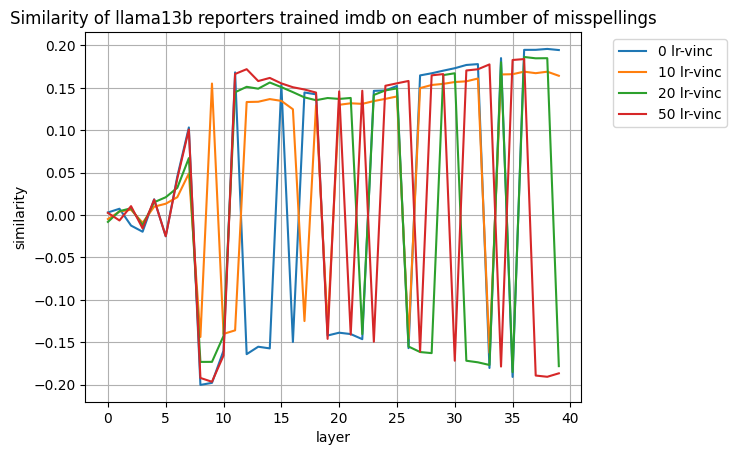

In [45]:
model = 'llama13b'

fig, ax = plt.subplots()
ax.set_title(fr"Similarity of {model} reporters trained imdb on each number of misspellings")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

# Set line colors and styles
# line_colors = ['black', 'blue', 'red', 'green', 'orange','purple', 'teal', 'pink', 'sage', 'grey']
# ccs_line_style = '--'
# lr_line_style = ':'
# zs_line_style = '-.'
for d in [0,10,20,50]:

    dataset = f"imdb_misspelled_{d}"
    if d == 0:

        #ax.plot(layers_arr, sim[(dataset, 'lr-lr2')], label = f"{d} lr-lr2")
        #ax.plot(layers_arr, sim[(dataset, 'lr-ccs')], label = f"{d} lr-ccs")
        ax.plot(layers_arr, sim[(dataset, 'lr-vinc')], label = f"{d} lr-vinc")

    else:

        #ax.plot(layers_arr, sim[(dataset, 'lr-lr2')], label = f"{d} lr-lr2")
        #ax.plot(layers_arr, sim[(dataset, 'lr-ccs')], label = f"{d} lr-ccs")
        ax.plot(layers_arr, sim[(dataset, 'lr-vinc')], label = f"{d} lr-vinc")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
model = 'llama13b'

fig, ax = plt.subplots()
ax.set_title(fr"{model} trained and tested on imdb, similarity between LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

# Set line colors and styles
# line_colors = ['black', 'blue', 'red', 'green', 'orange','purple', 'teal', 'pink', 'sage', 'grey']
# ccs_line_style = '--'
# lr_line_style = ':'
# zs_line_style = '-.'
    
ax.plot(layers_arr,sim)

# experiment = data[(model, train_dataset, test_dataset, 'ccs')]
# layers = experiment['layer']
# acc = experiment['acc']
# ax.plot(layers, acc, label=f'CCS tested on {test_dataset}',
#             color=line_color, linestyle=ccs_line_style)

# if 'lm_acc' in experiment.columns:
#     lm_acc = experiment['lm_acc']
#     # Set line color and style for zero-shot dataset
#     ax.plot(layers, lm_acc, label='zero-shot language model output',
#             color=line_color, linestyle=zs_line_style)

# if 'lr_acc' in experiment.columns:
#     lr_acc = experiment['lr_acc']
#     # Set line color and style for logistic regression dataset
#     ax.plot(layers, lr_acc, label='logistic regression',
#             color=line_color, linestyle=lr_line_style)
                
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [27]:
a = torch.tensor([[3,4],[5,12]], dtype=torch.float)
b = torch.norm(a, dim=-1, keepdim=True)
print(b)
print(a/b)

tensor([[ 5.],
        [13.]])
tensor([[0.6000, 0.8000],
        [0.3846, 0.9231]])
